In [11]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, os.path.abspath('../src'))
from shallowwater import (ModelParams, make_grid, setup_initial_state,
                          zero_forcing, run_model, compute_dt_cfl)
import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# --- Seiche test case (standing wave; no forcing, no friction, non-rotating) ---

# Grid / basin
Nx, Ny = 64, 64
Lx, Ly = 2.0e6, 2.0e6     # 2000 km x 2000 km (keep your usual sizes if you like)
grid = make_grid(Nx, Ny, Lx, Ly)

# Non-rotating, inviscid, linear
params = ModelParams(H=1000.0, g=9.81, rho=1025.0,
                     f0=0.0, beta=0.0, y0=Ly/2,
                     r=0.0, linear=True)

# Theoretical period for seiche mode (m,n): ω = π c √[(m/Lx)^2 + (n/Ly)^2],  c = √(gH)
c = np.sqrt(params.g * params.H)
m, n = 1, 1                     # fundamental along x
omega = np.pi * c * np.sqrt((m/Lx)**2 + (n/Ly)**2)
T_mn = 2*np.pi / omega          # seconds
print(f"Fundamental (m={m}, n={n}) seiche period T ≈ {T_mn/3600:.2f} h  (~{T_mn/86400:.2f} days)")

# CFL step and duration: simulate several periods
dt = compute_dt_cfl(grid, params, cfl=0.5)
tmax = 3.0 * T_mn

# Initial condition: standing-mode free surface, zero velocities
def seiche_ic(g, p, A=0.10, m=1, n=0):      # A in meters (small: linear regime)
    X, Y = np.meshgrid(g.x_c, g.y_c)
    eta = A * np.cos(m * np.pi * X / g.Lx) * (np.cos(n * np.pi * Y / g.Ly) if n>0 else 1.0)
    u = np.zeros((g.Ny, g.Nx + 1))
    v = np.zeros((g.Ny + 1, g.Nx))
    return eta, u, v

ic_fn = lambda g, p: seiche_ic(g, p, A=0.10, m=m, n=n)

# No external forcing
forcing_fn = lambda t, g, p: zero_forcing(t, g, p)

# Save often enough to resolve the oscillation
out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=10, out_vars=('eta','u'))

print('Saved steps:', len(out['time']))


Fundamental (m=1, n=1) seiche period T ≈ 7.93 h  (~0.33 days)
Saved steps: 55


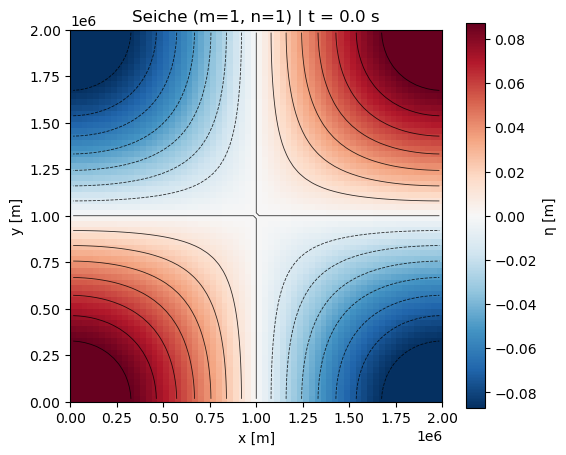

In [13]:
from shallowwater import animate_eta

# Visualize eta(x,y,t) as an animation and display it inline
anim = animate_eta(out, grid, interval=120, title="Seiche (m=1, n=1)")  # interval in ms

# GIF (no external dependencies)
anim.save("eta_06.gif", fps=10)

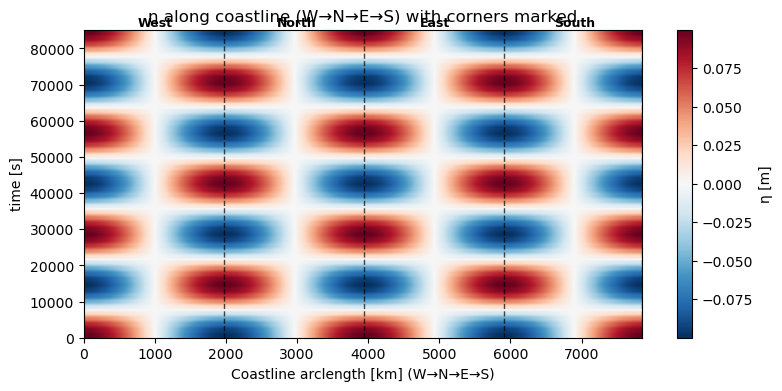

In [14]:
from shallowwater.visualize import coast_hovmoller

fig = coast_hovmoller(out, grid, units_x="km",
                      title="η along coastline (W→N→E→S) with corners marked")